In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing neccessary libraries
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import random


import warnings
warnings.filterwarnings("ignore")

## `Reading The Data `

In [3]:
df = pd.read_csv(r"/kaggle/input/faces-age-detection-dataset/faces/train.csv")

age_group = {
    "YOUNG": 0,
    "MIDDLE": 1,
    "OLD": 2
}

df['target'] = df['Class'].map(age_group)

df.head()

,ID,Class,target
0,377.jpg,MIDDLE,1
1,17814.jpg,YOUNG,0
2,21283.jpg,MIDDLE,1
3,16496.jpg,YOUNG,0
4,4487.jpg,MIDDLE,1


In [4]:
# Showing the distribution of classes in the data 
class_count = df['Class'].value_counts()
class_count

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

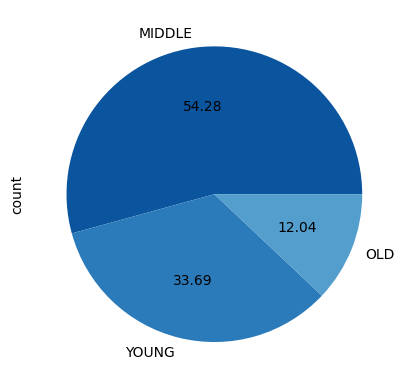

In [5]:
class_count.plot.pie(autopct = "%.2f", colors = sns.color_palette("Blues_r"));

(182, 120, 3)

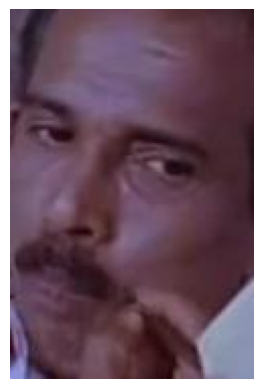

In [8]:
folder_path = '/kaggle/input/faces-age-detection-dataset/faces/Train'
files = os.listdir(folder_path)
x = plt.imread(os.path.join(folder_path, files[2]))
plt.axis("off")
plt.imshow(x)
x.shape

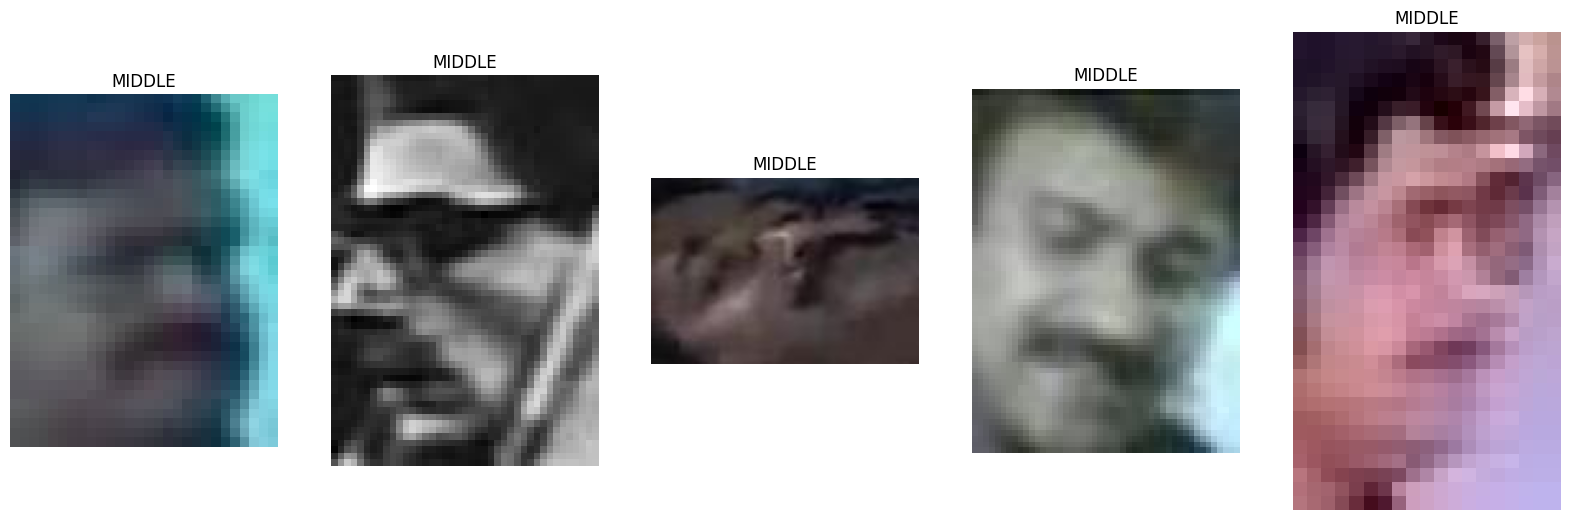

In [9]:
N = 5 
plt.figure(figsize=(20, 10))

for i, file in enumerate(files[N+5:N + 10]):
    
    # Construct full file path
    image_path = os.path.join(folder_path, file)
    # Load the image
    img = plt.imread(image_path)
    # Plot the image
    plt.subplot(1, N, i+1)
    plt.imshow(img)
    plt.title(df.loc[df['ID'] == file, "Class"].item())
    plt.xlabel(img.shape)
    plt.axis('off')

plt.show()

In [10]:
# Reading the images in the dataframe.
df['image'] = pd.Series(
    [plt.imread(os.path.join(folder_path, id)) for id in df['ID']]
)

df.head()

,ID,Class,target,image
0,377.jpg,MIDDLE,1,"[[[51, 47, 48], [51, 47, 48], [46, 44, 45], [4..."
1,17814.jpg,YOUNG,0,"[[[47, 30, 36], [47, 30, 36], [47, 30, 36], [4..."
2,21283.jpg,MIDDLE,1,"[[[44, 40, 39], [44, 40, 39], [46, 40, 40], [4..."
3,16496.jpg,YOUNG,0,"[[[21, 21, 21], [21, 21, 21], [21, 21, 21], [2..."
4,4487.jpg,MIDDLE,1,"[[[32, 31, 37], [30, 29, 35], [27, 26, 32], [2..."


## `Image Augmentation` 

In [ ]:
imggen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range = (0.4, 0.55),
    horizontal_flip = True,
    width_shift_range = 0.22,
)

In [ ]:
aug_img = []
class_list = []
common_shape = (180, 180) 
max_generated_images_per_class = 6000

for c in df['Class'].unique():
    
    all_class_images = df.loc[df['Class'] == c, "image"]
    num_generated_images = 0
    
    for class_idx, class_images in enumerate(all_class_images):

        #  resizing
        resized_images = [cv2.resize(img, common_shape) for img in all_class_images]
#         resized_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in resized_images] 
#         resized_images = [tf.image.rgb_to_grayscale(img) for img in resized_images]
        resized_images = np.stack(resized_images)
        
        # Generate augmented images using the data generator
        aug_images = imggen.flow(
            x = resized_images,
            batch_size = 1,
            save_format = "jpg",
            shuffle = False
        )
        
        for img in aug_images:
            aug_img.extend(img)
            num_generated_images += 1
        
            if num_generated_images >= max_generated_images_per_class:
                class_list.extend([age_group[c]] * (num_generated_images))
                break
                
        if num_generated_images >= max_generated_images_per_class:
            break


In [11]:
def augment_image(image, target_size):
    # Rotation
    angle = random.uniform(-30, 30)
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))
    
    # Flipping
    if random.choice([True, False]):
        image = cv2.flip(image, 1)  # Horizontal flip
    if random.choice([True, False]):
        image = cv2.flip(image, 0)  # Vertical flip
    
    # Scaling
    scale_factor = random.uniform(0.8, 1.2)
    image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    
    # Ensure image size is consistent
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Translation
    x = random.randint(-10, 10)
    y = random.randint(-10, 10)
    M = np.float32([[1, 0, x], [0, 1, y]])
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    
    # Brightness adjustment
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = cv2.multiply(hsv[:, :, 2], random.uniform(0.5, 1.5))
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return image

def generate_augmented_images(df, num_augmented_per_class = 10000):
    augmented_images = []
    augmented_labels = []
    
    for label in df['target'].unique():
        class_images = df[df['target'] == label]['image']
        num_original_images = len(class_images)
        num_images_needed = num_augmented_per_class - num_original_images
        num_gen_images = 0
        
        if num_original_images == 0:
            continue
        
        # Get target size from the first image
        target_size = (180, 180)
        
        augmented_images_for_class = []
        while num_images_needed > 0:
            for image in class_images:
                augmented_image = augment_image(image, target_size)
                augmented_images_for_class.append(augmented_image)
                num_images_needed -= 1
                num_gen_images += 1
                if num_images_needed <= 0:
                    break
        
        # Add original images resized to the target size
        for image in class_images:
            resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
            augmented_images.append(resized_image)
            augmented_labels.append(label)
        
        augmented_images.extend(augmented_images_for_class)
        augmented_labels.extend([label] * len(augmented_images_for_class))
    
    return np.array(augmented_images), np.array(augmented_labels)


augmented_images, augmented_labels = generate_augmented_images(df)


aug_imgs, class_list = shuffle(augmented_images, augmented_labels, random_state=42)

# Print the total number of augmented images
print(f"Total number of augmented images: {len(aug_imgs)}")

# Ensure both arrays have the same length
assert len(aug_imgs) == len(class_list), "Mismatch in number of images and labels"

Total number of augmented images: 30804


The image class: 1 and its shape: (180, 180, 3)


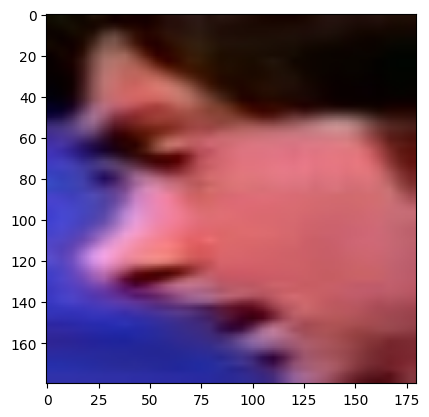

In [12]:
plt.imshow(augmented_images[22]) 
print(f"The image class: {augmented_labels[22]} and its shape: {augmented_images[22].shape}")

In [13]:
aug_imgs, class_list = shuffle(augmented_images, augmented_labels, random_state=42)

# Print the total number of augmented images
print(f"Total number of augmented images: {len(aug_imgs)}")
print(f"Total number of augmented classes:\n{pd.Series(class_list).value_counts()}")

Total number of augmented images: 30804
Total number of augmented classes:
1    10804
0    10000
2    10000
Name: count, dtype: int64


In [14]:
# Shuffling the dataframe
# train_df = train_df.sample(frac=1).reset_index(drop=True)

# Splitting the data into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(aug_imgs, class_list,
                                                  test_size=0.2, random_state=42)

print(f"X train Shape: {X_train.shape}")
print(f"X Validation Shape: {X_val.shape}")
print(f"y Train Shape: {y_train.shape}")
print(f"y Validation Shape: {y_val.shape}")


X train Shape: (24643, 180, 180, 3)
X Validation Shape: (6161, 180, 180, 3)
y Train Shape: (24643,)
y Validation Shape: (6161,)


# `Model Implementation`

In [15]:
input_shape = (180, 180, 3)

# Load ResNet50 with pre-trained ImageNet weights, excluding the top layers
resnet_base = ResNet50(weights='imagenet',
                       include_top = False,
                       input_shape = input_shape)

# Freeze the layers of ResNet50 to avoid retraining them
for layer in resnet_base.layers:
    layer.trainable = False

# Define the model
model = Sequential([
    resnet_base,  
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax'),
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32

In [16]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 0.00001)
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)

history = model.fit(
    X_train, y_train, 
    epochs = 10, 
    validation_data = (X_val, y_val), 
    callbacks = [reduce_lr]
)

Epoch 1/10


I0000 00:00:1723378329.773290     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


771/771 [==============================] - 53s 57ms/step - loss: 0.7901 - accuracy: 0.6777 - val_loss: 0.5121 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 2/10
771/771 [==============================] - 41s 53ms/step - loss: 0.5266 - accuracy: 0.7794 - val_loss: 0.4759 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 3/10
771/771 [==============================] - 41s 53ms/step - loss: 0.4440 - accuracy: 0.8206 - val_loss: 0.4902 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 4/10
771/771 [==============================] - 41s 53ms/step - loss: 0.3715 - accuracy: 0.8533 - val_loss: 0.4596 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 5/10
771/771 [==============================] - 41s 53ms/step - loss: 0.3247 - accuracy: 0.8724 - val_loss: 0.4787 - val_accuracy: 0.8064 - lr: 0.0010
Epoch 6/10
771/771 [==============================] - 41s 53ms/step - loss: 0.2808 - accuracy: 0.8910 - val_loss: 0.4818 - val_accuracy: 0.8143 - lr: 0.0010
Epoch 7/10
771/771 [==============================] - 41s 53ms/step -

In [33]:
print(tf.__version__)


2.15.0


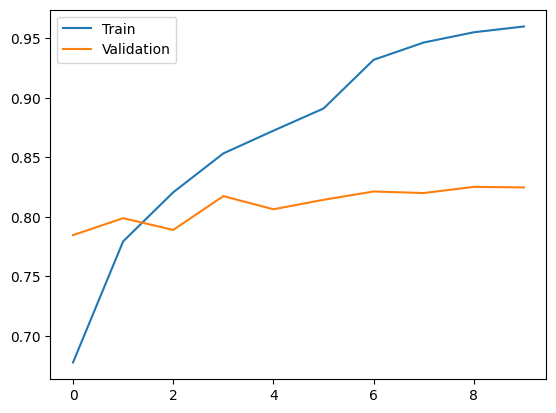

In [17]:
plt.plot(history.history["accuracy"]);
plt.plot(history.hiastory["val_accuracy"]);
plt.legend(['Train', 'Validation'], loc='upper left');

### `Saving The Model` 

In [21]:
os.listdir("/kaggle/working/")

['Age-Detector-Model-95.h5', '.virtual_documents']

In [20]:
model.save(r"/kaggle/working/Age-Detector-Model-95.h5")

### `Generalizing on the test data` 

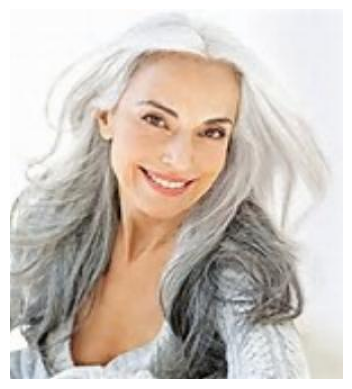

In [22]:
test_path = f"{os.getcwd()}/../input/faces-age-detection-dataset/faces_02/part3"
test_files = os.listdir(test_path)

test_x = plt.imread(os.path.join(test_path, test_files[3200]))

plt.axis("off")
plt.imshow(test_x)

In [23]:
# Processing the test data for the model
def preprocess_test_image(image):
    # Resize the image to the target size
    image_resized = cv2.resize(image, (180, 180), interpolation=cv2.INTER_LINEAR)
    
    # Normalize pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0
    
    image_expaned = np.expand_dims(image_normalized, axis=0)
    
    return image_expaned

def predict_class(pred_model, image):
    
    processed_img = preprocess_test_image(image)
    # Getting the predicted probabilities from the model 
    pred_probas = pred_model.predict(processed_img)
    # Obtaining the preidcted class
    pred_class = pred_probas.argmax()
    
    return list(age_group.keys())[pred_class]

In [27]:
# Loading the model for prediction
l_model = load_model(r"/kaggle/working/Age-Detector-Model-95.h5")

1/1 [==============================] - 1s 1s/step
Class: MIDDLE


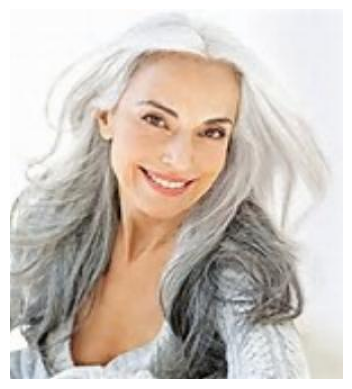

In [28]:
plt.axis("off")
plt.imshow(test_x)

pred = predict_class(l_model, test_x)
print(f"Class: {pred}")